In [33]:
import cv2
import numpy as np
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
def load_images(path):
    os.chdir(path)
    images = []
    for f in os.listdir():
        img = cv2.imread(f)
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return np.array(images).reshape(len(images), -1)

base_dir = '/content/drive/My Drive/Colab Notebooks/VisionLab/Cohn-Kanade/images/'
x_h = load_images(base_dir + 'happy')
x_s = load_images(base_dir + 'surprise')
x_n = load_images(base_dir + 'neutral')

## Section 1

We first split the data into training and test sets and then combine the samples from different classes into a single, consolidated set.

We reduce the dimension of the images down to the first 50 principal components (using PCA) and standardize the results for improved numerical stability.

Finally, we create the corresponding y labels for the multi-class classifier.

In [35]:
X_train_h, X_test_h = train_test_split(x_h, train_size=0.8, random_state=42)
X_train_s, X_test_s = train_test_split(x_s, train_size=0.8, random_state=42)
X_train_n, X_test_n = train_test_split(x_n, train_size=0.8, random_state=42)

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train = np.vstack([X_train_h, X_train_s, X_train_n])
X_test = np.vstack([X_test_h, X_test_s, X_test_n])

n_components = 50
pca = PCA(n_components=n_components)
pca.fit(X_train)

# Transform both train and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

y_train = np.concatenate([
    np.zeros(X_train_h.shape[0]),
    np.ones(X_train_s.shape[0]),
    np.full(X_train_n.shape[0], 2)
])

y_test = np.concatenate([
    np.zeros(X_test_h.shape[0]),
    np.ones(X_test_s.shape[0]),
    np.full(X_test_n.shape[0], 2)
])

To determine the optimal parameters for the Support Vector Machine, k-fold cross-validation was employed.

 In this function, data is split into $k$ sets. Each time, $k-1$ sets are used to train the model, and the last one is used for the validation of the model. This process is repeated for all $k$ sets, and the average result is reported as the final score.

In [58]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def numpy_k_fold_split_minimal(X, n_splits=5, shuffle=True, random_state=None):
    n_samples = len(X)
    indices = np.arange(n_samples)

    if shuffle:
        if random_state is not None:
            np.random.seed(random_state)
        np.random.shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1

    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_indices = indices[start:stop]
        train_indices = np.setdiff1d(indices, val_indices)
        current = stop
        yield (train_indices, val_indices)


def find_optimal_c_svm(X_train, y_train, c_values, n_splits=5, random_state=42):
    results = {}

    splitter = numpy_k_fold_split_minimal(X_train, n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = list(splitter)

    print(f"Starting Cross-Validation Grid Search with {n_splits} folds...")
    print(f"Testing C values: {c_values}")

    for C in c_values:
        fold_scores = []

        for fold_num, (train_idx, val_idx) in enumerate(splits):
            X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
            X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]

            model = SVC(C=C, random_state=random_state)
            model.fit(X_fold_train, y_fold_train)

            y_pred = model.predict(X_fold_val)
            score = accuracy_score(y_fold_val, y_pred)
            fold_scores.append(score)

        avg_score = np.mean(fold_scores)
        results[C] = avg_score
        print(f"C={C:<10} | Avg. Score: {avg_score:.4f} (Std Dev: {np.std(fold_scores):.4f})")

    best_c = max(results, key=results.get)
    print(f"\nOptimal C found: {best_c} with average score: {results[best_c]:.4f}")

    return results, best_c

In [59]:
C_GRID = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

scores, optimal_c = find_optimal_c_svm(
    X_train=X_train_scaled,
    y_train=y_train,
    c_values=C_GRID,
    n_splits=10
)

Starting Cross-Validation Grid Search with 10 folds...
Testing C values: [0.001, 0.01, 0.1, 1, 10.0, 100.0]
C=0.001      | Avg. Score: 0.5241 (Std Dev: 0.0798)
C=0.01       | Avg. Score: 0.5241 (Std Dev: 0.0798)
C=0.1        | Avg. Score: 0.5241 (Std Dev: 0.0798)
C=1          | Avg. Score: 0.7552 (Std Dev: 0.0625)
C=10.0       | Avg. Score: 0.8655 (Std Dev: 0.0662)
C=100.0      | Avg. Score: 0.8621 (Std Dev: 0.0597)

Optimal C found: 10.0 with average score: 0.8655


In [67]:
svm = SVC(kernel='linear', C=100)
svm.fit(X_train_scaled, y_train)

SVC(C=100, kernel='linear')

The following results indicate that these images are linearly separable with high accuracy.

Accuracy: 90.41


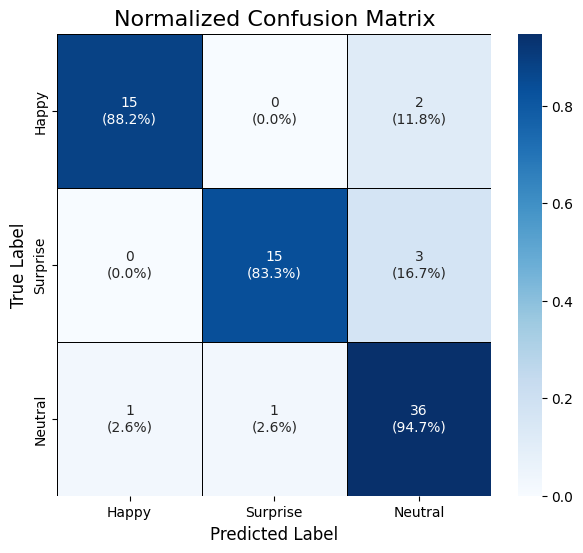

In [68]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def calculate_and_plot_metrics(y_true, y_pred, class_names, average_method='weighted'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_method, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average_method, zero_division=0)

    cm_raw = confusion_matrix(y_true, y_pred)

    cm_norm = np.divide(
        cm_raw,
        cm_raw.sum(axis=1)[:, np.newaxis],
        out=np.zeros_like(cm_raw, dtype=float),
        where=cm_raw.sum(axis=1)[:, np.newaxis] != 0
    )

    annot_labels = np.asarray([
        f"{raw_count}\n({norm_val:.1%})"
        for raw_count, norm_val in zip(cm_raw.flatten(), cm_norm.flatten())
    ]).reshape(cm_raw.shape)

    metrics = {
        "Accuracy": accuracy,
        f"Precision ({average_method})": precision,
        f"Recall ({average_method})": recall
    }
    print(f'Accuracy: {accuracy*100:.2f}')
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm_norm,
        annot=annot_labels,
        fmt='s',
        cmap='Blues',
        cbar=True,
        linewidths=.5,
        linecolor='black',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    return metrics, cm_raw

CLASS_NAMES = ['Happy', 'Surprise', 'Neutral']

y_pred = svm.predict(X_test_scaled)
metrics_results, confusion_matrix_data = calculate_and_plot_metrics(
    y_true=y_test,
    y_pred=y_pred,
    class_names=CLASS_NAMES
)

## Section 2

we now perform $k$-fold cross-validation for both the regularization parameter $C$ and the kernel coefficient $\gamma$ hyperparameters for the $\text{RBF}$ kernel.

$$K(\mathbf{x}, \mathbf{x}') = \exp(-\gamma ||\mathbf{x} - \mathbf{x}'||^2)$$

In [69]:
def find_optimal_rbf_grid(X_train, y_train, c_values, gamma_values, n_splits=5, random_state=42):
    results = {}
    best_score = -np.inf
    best_params = {'C': None, 'gamma': None}

    splitter = numpy_k_fold_split_minimal(X_train, n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = list(splitter)

    print(f"Starting Cross-Validation Grid Search with {n_splits} folds...")
    print(f"Testing {len(c_values) * len(gamma_values)} parameter combinations.")

    for gamma in gamma_values:

        for C in c_values:
            fold_scores = []

            for train_idx, val_idx in splits:

                X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
                X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]

                model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=random_state)
                model.fit(X_fold_train, y_fold_train)

                y_pred = model.predict(X_fold_val)
                score = accuracy_score(y_fold_val, y_pred)
                fold_scores.append(score)

            avg_score = np.mean(fold_scores)

            results[(C, gamma)] = avg_score

            if avg_score > best_score:
                best_score = avg_score
                best_params['C'] = C
                best_params['gamma'] = gamma

            print(f"C={C:<8} | Gamma={gamma:<8} | Avg. Score: {avg_score:.4f}")

    print("-" * 40)
    print(f"Optimal Parameters: C={best_params['C']}, Gamma={best_params['gamma']}")
    print(f"Highest Average Score: {best_score:.4f}")

    return results, best_params

In [70]:
C_GRID = [0.01, 0.1, 1.0, 10.0, 100.0]
GAMMA_GRID = [0.001, 0.01, 0.1, 1.0]

scores, optimal_params = find_optimal_rbf_grid(
    X_train=X_train_scaled,
    y_train=y_train,
    c_values=C_GRID,
    gamma_values=GAMMA_GRID,
    n_splits=10
)

Starting Cross-Validation Grid Search with 10 folds...
Testing 20 parameter combinations.
C=0.01     | Gamma=0.001    | Avg. Score: 0.5241
C=0.1      | Gamma=0.001    | Avg. Score: 0.5241
C=1.0      | Gamma=0.001    | Avg. Score: 0.5241
C=10.0     | Gamma=0.001    | Avg. Score: 0.8655
C=100.0    | Gamma=0.001    | Avg. Score: 0.8828
C=0.01     | Gamma=0.01     | Avg. Score: 0.5241
C=0.1      | Gamma=0.01     | Avg. Score: 0.5241
C=1.0      | Gamma=0.01     | Avg. Score: 0.8448
C=10.0     | Gamma=0.01     | Avg. Score: 0.8897
C=100.0    | Gamma=0.01     | Avg. Score: 0.8793
C=0.01     | Gamma=0.1      | Avg. Score: 0.5241
C=0.1      | Gamma=0.1      | Avg. Score: 0.5241
C=1.0      | Gamma=0.1      | Avg. Score: 0.4897
C=10.0     | Gamma=0.1      | Avg. Score: 0.4724
C=100.0    | Gamma=0.1      | Avg. Score: 0.4724
C=0.01     | Gamma=1.0      | Avg. Score: 0.5241
C=0.1      | Gamma=1.0      | Avg. Score: 0.5241
C=1.0      | Gamma=1.0      | Avg. Score: 0.5241
C=10.0     | Gamma=1.0      

In [71]:
svm = SVC(kernel='rbf', C=10, gamma=0.01)
svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.01)

We observe that the optimal kernel coefficient, $\gamma$, determined by $k$-fold cross-validation, is relatively small at $\mathbf{0.01}$.
This small value causes the RBF kernel to approximate a linear kernel, which is expected given the linearly separable nature of the data.
Consequently, the results closely resemble the linear case.

$$ \exp(-\gamma ||\mathbf{x} - \mathbf{x}'||^2) \approx -\gamma ||\mathbf{x} - \mathbf{x}'||^2 $$

Accuracy: 93.15


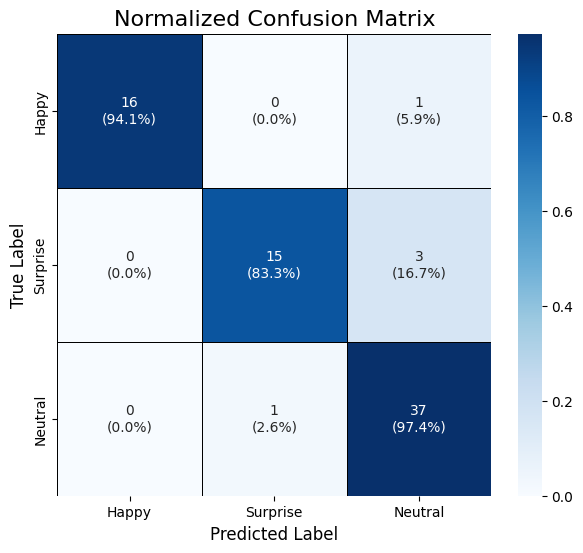

In [72]:
y_pred = svm.predict(X_test_scaled)
metrics_results, confusion_matrix_data = calculate_and_plot_metrics(
    y_true=y_test,
    y_pred=y_pred,
    class_names=CLASS_NAMES
)
